In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

QBER_THRESHOLD = 0.11 # Standard threshold for eavesdropping/excessive noise detection (Commonly used)

# PROTOCOL FUNCTION

In [2]:
def bb84_protocol(n_qubits=10, noise_prob=0.0, eve_prob=0.0):
    """
    Full BB84 protocol simulation.
    """
    effective_gate_noise = noise_prob
    effective_readout_noise = noise_prob + (eve_prob * 0.25)

    alice_bits = np.random.randint(2, size=n_qubits).astype(int)
    alice_bases = np.random.randint(2, size=n_qubits).astype(int)
    bob_bases = np.random.randint(2, size=n_qubits).astype(int)
    
    qc = QuantumCircuit(n_qubits, n_qubits)
    
    # Alice encodes
    for i in range(n_qubits):
        if alice_bits[i] == 1:
            qc.x(i)
        if alice_bases[i] == 1:
            qc.h(i)
    qc.barrier()
  
    # Bob measures
    for i in range(n_qubits):
        if bob_bases[i] == 1:
            qc.h(i)
    qc.barrier()
    qc.measure(range(n_qubits), range(n_qubits))

    simulator = AerSimulator()
    if effective_gate_noise > 0 or effective_readout_noise > 0:
        noise_model = NoiseModel()
        if effective_gate_noise > 0:
            depol_error = depolarizing_error(effective_gate_noise, 1)
            noise_model.add_all_qubit_quantum_error(depol_error, ['h', 'x'])
        if effective_readout_noise > 0:
            readout_probs = [[1 - effective_readout_noise, effective_readout_noise], [effective_readout_noise, 1 - effective_readout_noise]]
            readout_error = ReadoutError(readout_probs)
            noise_model.add_all_qubit_readout_error(readout_error)
        simulator = AerSimulator(noise_model=noise_model)
    job = simulator.run(qc, shots=1)
    result = job.result()
    counts = result.get_counts()
    measured_str = max(counts, key=counts.get)
    measured_bits = [int(bit) for bit in reversed(measured_str)]

    sifted_indices = [i for i in range(n_qubits) if alice_bases[i] == bob_bases[i]]
    alice_sifted = [int(alice_bits[i]) for i in sifted_indices]
    bob_sifted = [measured_bits[i] for i in sifted_indices]
    sifted_length = len(sifted_indices)

    if sifted_length == 0:
        return {'qber': 1.0, 'sifted_length': 0, 'key_length': 0, 'detected_eve': True, 'alice_sifted_key': [], 'bob_sifted_key': [], 'alice_final_key': [], 'bob_final_key': []}
    est_size = max(1, sifted_length // 2)
    est_indices = np.random.choice(range(sifted_length), est_size, replace=False)
    errors = sum(alice_sifted[j] != bob_sifted[j] for j in est_indices)
    qber = errors / est_size

    total_errors = sum(alice_sifted[j] != bob_sifted[j] for j in range(sifted_length))
    total_qber = total_errors / sifted_length
    detected_eve = (qber > QBER_THRESHOLD) or (total_errors > 0)  # Sensitive to any error

    key_indices = [j for j in range(sifted_length) if j not in set(est_indices)]
    matching_key_indices = [j for j in key_indices if alice_sifted[j] == bob_sifted[j]]
    alice_final_key = [int(alice_sifted[j]) for j in matching_key_indices]
    bob_final_key = [bob_sifted[j] for j in matching_key_indices]
    key_length = len(matching_key_indices)
    
    return {
        'qber': qber,
        'sifted_length': sifted_length,
        'key_length': key_length,
        'detected_eve': detected_eve,
        'alice_sifted_key': alice_sifted,
        'bob_sifted_key': bob_sifted,
        'alice_final_key': alice_final_key,
        'bob_final_key': bob_final_key
    }    

# DISPLAY RESULT FUNCTION
For better visual clarity viewing it as output.

In [3]:
def print_bb84_results(title, metrics, eve_prob=0, print_keys=True):
    """Prints BB84 metrics in a user-friendly format, including sifted keys."""
    print(f"\n## {title}")
    print("--------------------------------------------------")
    print(f"** QBER (Error Rate): ** {metrics['qber']:.4f}")
    print(f"** QBER Threshold: ** {QBER_THRESHOLD:.2f}")
  
    if metrics['detected_eve']:
        if "Eavesdropping" in title:
            if eve_prob > 0:
                detection_text = 'Eavesdropping Attack Detected!'
        else:
            detection_text = 'High Noise/Unsafe Channel Detected'
    else:
        if "Eavesdropping" in title and eve_prob > 0:
            detection_text = 'Missed Eavesdropping Attack? (Low QBER Sample)'
        else:
            detection_text = 'Secure Channel'
    print(f"** Security Check: ** {detection_text}")
    print(f"** Sifted Key Length: ** {metrics['sifted_length']} bits")
    print(f"** Final Key Length: ** {metrics['key_length']} bits")
  
    if print_keys and metrics['sifted_length'] < 30:
        print("-" * 50)
        print(f"Alice's Sifted Key: {metrics['alice_sifted_key']}")
        print(f"Bob's Sifted Key: {metrics['bob_sifted_key']}")
        print("-" * 50)
        print(f"Alice's Final Key: {metrics['alice_final_key']}")
        print(f"Bob's Final Key: {metrics['bob_final_key']}")
    
    key_match = all(a == b for a, b in zip(metrics['alice_final_key'], metrics['bob_final_key']))
    print(f"Final Key Match Check: {'Perfect Match' if key_match else 'Mismatch'}")
      
    print("--------------------------------------------------")

# RUNNING SCENARIOS

How to run different scenarios:
| Scenario | Parameter |
|:- | -:|
| Ideal Channel | ynn |
| Natural Noise | nyn |
| Eavesdropping | nny |

In [4]:
def run_scenarios(n_qubits=10, scenario = 'yyy'):
    """Runs and prints results for key BB84 scenarios."""
    print(f"\n--- Running Key Scenarios (N_QUBITS={n_qubits}) ---")
    if scenario[0] == "y":
        # Scenario 1: Ideal Channel (No Noise, No Eve)
        metrics_ideal = bb84_protocol(n_qubits=n_qubits, noise_prob=0.0, eve_prob=0.0)
        print_bb84_results("1. Ideal Channel (Secure)", metrics_ideal)
    if scenario[1] == "y":
        # Scenario 2: High Natural Noise (No Eve)
        metrics_noisy = bb84_protocol(n_qubits=n_qubits, noise_prob=0.1, eve_prob=0.0)
        print_bb84_results("2. High Natural Noise (No Eve)", metrics_noisy)
    if scenario[2] == "y":
        # Scenario 3: Eavesdropping with (No Noise)
        metrics_eve = bb84_protocol(n_qubits=n_qubits, noise_prob=0.0, eve_prob=1.0)
        print_bb84_results("3. Eavesdropping Attack (No Noise)", metrics_eve, 1) # added eve_prob=1, as we are checing if eavesdropping is detected or not

In [5]:
run_scenarios(10, 'nyy')


--- Running Key Scenarios (N_QUBITS=10) ---

## 2. High Natural Noise (No Eve)
--------------------------------------------------
** QBER (Error Rate): ** 0.5000
** QBER Threshold: ** 0.11
** Security Check: ** High Noise/Unsafe Channel Detected
** Sifted Key Length: ** 4 bits
** Final Key Length: ** 2 bits
--------------------------------------------------
Alice's Sifted Key: [0, 0, 1, 0]
Bob's Sifted Key: [0, 1, 1, 0]
--------------------------------------------------
Alice's Final Key: [1, 0]
Bob's Final Key: [1, 0]
Final Key Match Check: Perfect Match
--------------------------------------------------

## 3. Eavesdropping Attack (No Noise)
--------------------------------------------------
** QBER (Error Rate): ** 0.0000
** QBER Threshold: ** 0.11
** Security Check: ** Missed Eavesdropping Attack? (Low QBER Sample)
** Sifted Key Length: ** 3 bits
** Final Key Length: ** 2 bits
--------------------------------------------------
Alice's Sifted Key: [1, 0, 1]
Bob's Sifted Key: [1, 0,

# PLOT DATA COLLECTION AND PLOT CREATION FUNCTION

In [6]:
def collect_metrics_for_plotting(n_runs=10, n_qubits=10):
    """Collects average QBER and detection rate across varying noise and Eve levels."""
  
    # 1. Quantum Noise (Eve_prob = 0)
    noise_levels = np.linspace(0, 0.15, 7)
    results_noise = {'x': noise_levels, 'qber': []}
    for noise in noise_levels:
        qbers = []
        for _ in range(n_runs):
            m = bb84_protocol(n_qubits=n_qubits, noise_prob=noise, eve_prob=0.0)
            qbers.append(m['qber'])
        results_noise['qber'].append(np.mean(qbers))
        
    # 2. Eavesdrop Attack (Noise_prob = 0)
    eve_levels = np.linspace(0, 1.0, 7)
    results_eve = {'x': eve_levels, 'qber': [], 'detection_rate': []}
    for eve_p in eve_levels:
        qbers, detections = [], []
        for _ in range(n_runs):
            m = bb84_protocol(n_qubits=n_qubits, noise_prob=0.0, eve_prob=eve_p)
            qbers.append(m['qber'])
            detections.append(1 if m['detected_eve'] else 0)
        results_eve['qber'].append(np.mean(qbers))
        results_eve['detection_rate'].append(np.mean(detections))
    return results_noise, results_eve
    
def plot_bb84_metrics_clear(results_noise, results_eve):
    """
    Generates two distinct plots (Noise and Eavesdropping), each with dual Y-axes
    for QBER and Detection Rate.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
  
    # --- Plot 1: Effect of Quantum Noise (No Eve) ---
    ax1_noise = axes[0]
    data_noise = results_noise
  
    # QBER line (Left Y-axis)
    ax1_noise.plot(data_noise['x'] * 100, data_noise['qber'], 'o-', color='blue', label='QBER (Left Axis)')
    ax1_noise.axhline(y=QBER_THRESHOLD, color='red', linestyle='--', label=f'QBER Threshold ({QBER_THRESHOLD*100:.0f}%)')
  
    ax1_noise.set_title('BB84 Security Metrics vs. Natural Channel Noise')
    ax1_noise.set_xlabel('Natural Noise Probability (%)')
    ax1_noise.set_ylabel('Quantum Bit Error Rate (QBER)', color='blue')
    ax1_noise.tick_params(axis='y', labelcolor='blue')
    ax1_noise.grid(True, alpha=0.6, axis='y', linestyle='--')
    
    # Combine legends
    lines, labels = ax1_noise.get_legend_handles_labels()
    ax1_noise.legend(lines, labels, loc='upper left')
  
    # --- Plot 2: Effect of Eavesdropping (No Quantum Noise) ---
    ax1_eve = axes[1]
    data_eve = results_eve
  
    # QBER line (Left Y-axis)
    ax1_eve.plot(data_eve['x'] * 100, data_eve['qber'], 'o-', color='green', label='QBER (Left Axis)')
    ax1_eve.axhline(y=QBER_THRESHOLD, color='red', linestyle='--', label=f'QBER Threshold ({QBER_THRESHOLD*100:.0f}%)')
    ax1_eve.axhline(y=0.25, color='gray', linestyle=':', label='Theoretical Max Eve QBER (0.25)')
  
    ax1_eve.set_title('BB84 Security Metrics vs. Eve Interception')
    ax1_eve.set_xlabel("Eve's Interception Probability (%)")
    ax1_eve.set_ylabel('Quantum Bit Error Rate (QBER)', color='green')
    ax1_eve.tick_params(axis='y', labelcolor='green')
    ax1_eve.grid(True, alpha=0.6, axis='y', linestyle='--')
    # Detection Rate line (Right Y-axis)
    ax2_eve = ax1_eve.twinx()
    ax2_eve.plot(data_eve['x'] * 100, data_eve['detection_rate'], 's--', color='purple', label='Detection Rate (Right Axis)')
  
    ax2_eve.set_ylabel('Detection Rate', color='purple')
    ax2_eve.tick_params(axis='y', labelcolor='purple')
    ax2_eve.set_ylim(0, 1.05)
    # Combine legends
    lines1, labels1 = ax1_eve.get_legend_handles_labels()
    lines2, labels2 = ax2_eve.get_legend_handles_labels()
    ax1_eve.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    plt.suptitle("BB84 Protocol Performance Analysis (QBER Threshold = 11%)", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# VISUALIZATION PLOTS

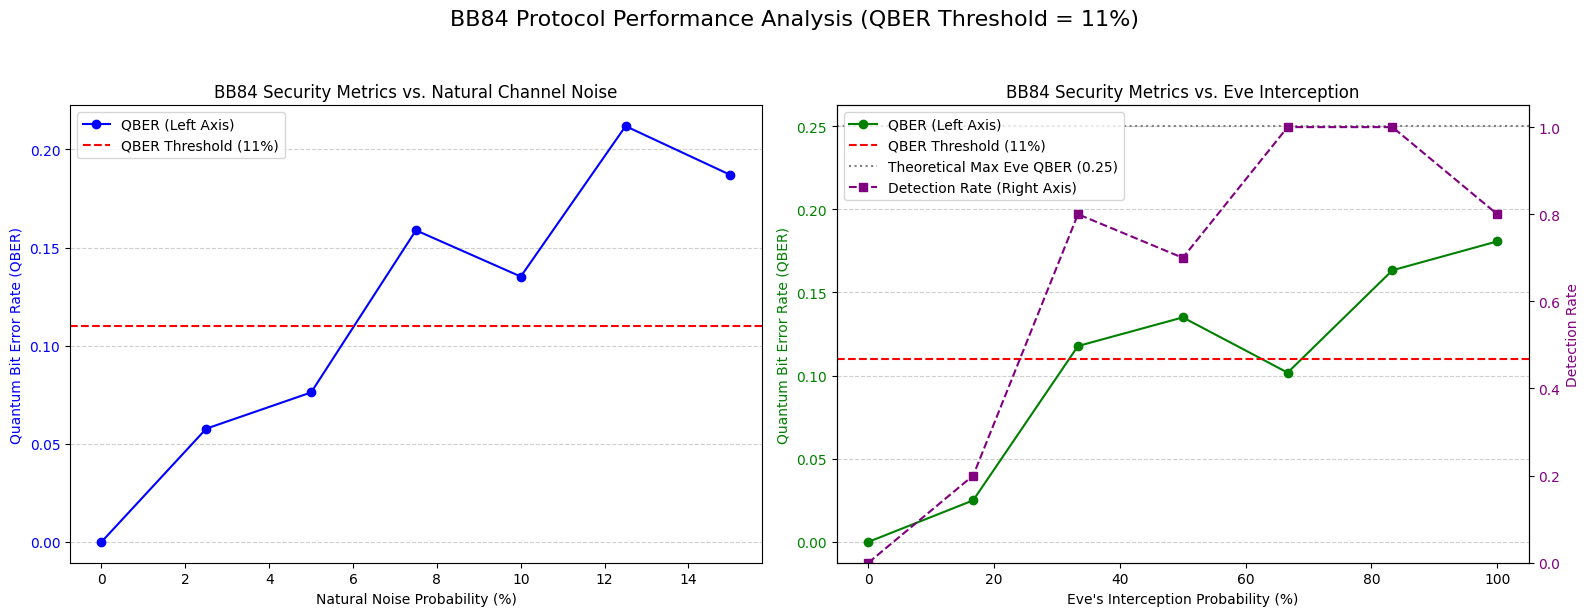


Simulation complete. Scenarios printed and plots generated.


In [8]:
results_noise, results_eve = collect_metrics_for_plotting(n_runs=10, n_qubits=25)
plot_bb84_metrics_clear(results_noise, results_eve)
print("\nSimulation complete. Scenarios printed and plots generated.")